In [ ]:
!pip install --upgrade --force-reinstall transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.0/763.0 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.9/798.9 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.8/485.8 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6

In [ ]:
!pip install -q transformers datasets scikit-learn nlpaug

import os
os.environ["WANDB_DISABLED"] = "true"

import pandas as pd, numpy as np, torch, torch.nn as nn
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import nlpaug.augmenter.word as naw

CSV = "/content/headlines_labeled.csv"
df = pd.read_csv(CSV)

for col in ["sentiment_label","sentiment","label"]:
    if col in df.columns:
        df = df.rename(columns={col:"sentiment_label"})
        break
assert "headline" in df.columns and "sentiment_label" in df.columns, "Need 'headline' and 'sentiment_label' columns"

def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s.,!?-]', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    return text.strip()

df["headline"] = df["headline"].apply(clean_text)
df["sentiment_label"] = df["sentiment_label"].str.lower().str.strip()
keep = df["sentiment_label"].isin(["negative","neutral","positive"]) & (df["headline"] != "") & df["headline"].notna()
df = df[keep].copy().reset_index(drop=True)

label2id = {"negative":0, "neutral":1, "positive":2}
id2label = {v:k for k,v in label2id.items()}
df["label"] = df["sentiment_label"].map(label2id)

print("Class counts:", df["sentiment_label"].value_counts().to_dict())

# 2) Data Augmentation for minority classes
def augment_data(df, target_samples=200):
    """Augment data to balance classes"""
    aug = naw.SynonymAug(aug_src='wordnet')
    augmented_data = []

    for label in [0, 1, 2]:  # negative, neutral, positive
        class_data = df[df["label"] == label]
        current_count = len(class_data)

        if current_count < target_samples:
            needed = target_samples - current_count

            # Sample headlines to augment
            to_augment = class_data.sample(n=min(needed, current_count), replace=True, random_state=42)

            for _, row in to_augment.iterrows():
                try:
                    augmented_text = aug.augment(row["headline"])
                    if isinstance(augmented_text, list):
                        augmented_text = augmented_text[0]

                    augmented_data.append({
                        "headline": augmented_text,
                        "sentiment_label": row["sentiment_label"],
                        "label": row["label"]
                    })
                except:
                    # If augmentation fails, just duplicate the original
                    augmented_data.append({
                        "headline": row["headline"],
                        "sentiment_label": row["sentiment_label"],
                        "label": row["label"]
                    })

    if augmented_data:
        aug_df = pd.DataFrame(augmented_data)
        df = pd.concat([df, aug_df], ignore_index=True)
        print("After augmentation:", df["sentiment_label"].value_counts().to_dict())

    return df

try:
    df = augment_data(df, target_samples=250)
except Exception as e:
    print(f"Augmentation failed: {e}, continuing without augmentation")

train_df, test_df = train_test_split(
    df[["headline","label"]],
    test_size=0.2, random_state=42, stratify=df["label"]
)

train_df, val_df = train_test_split(
    train_df,
    test_size=0.15, random_state=42, stratify=train_df["label"]
)

ds = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "validation": Dataset.from_pandas(val_df.reset_index(drop=True)),
    "test":  Dataset.from_pandas(test_df.reset_index(drop=True))
})

MODEL_NAME = "roberta-base"
tok = AutoTokenizer.from_pretrained(MODEL_NAME)

def tok_fn(b):
    return tok(b["headline"], truncation=True, padding="max_length", max_length=128)

ds_tok = ds.map(tok_fn, batched=True)
ds_tok = ds_tok.remove_columns([c for c in ds_tok["train"].column_names if c not in ["input_ids","attention_mask","label"]])
ds_tok.set_format(type="torch")

classes = np.array([0,1,2])
weights = compute_class_weight(class_weight="balanced", classes=classes, y=train_df["label"].values)
class_w = torch.tensor(weights, dtype=torch.float)
print("Class weights (neg,neu,pos):", class_w.tolist())

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1
)

def compute_metrics(p):
    preds = p.predictions.argmax(axis=1)
    acc = accuracy_score(p.label_ids, preds)
    f1_macro = f1_score(p.label_ids, preds, average="macro")
    f1_weighted = f1_score(p.label_ids, preds, average="weighted")
    return {
        "accuracy": acc,
        "macro_f1": f1_macro,
        "weighted_f1": f1_weighted
    }

class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

OUT_DIR = "/content/sent_chk_v3"


try:
    args = TrainingArguments(
        output_dir=OUT_DIR,
        num_train_epochs=8,
        per_device_train_batch_size=16,
        gradient_accumulation_steps=2,
        per_device_eval_batch_size=64,
        learning_rate=3e-5,
        weight_decay=0.1,
        warmup_ratio=0.1,
        lr_scheduler_type="cosine",
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        greater_is_better=True,
        logging_steps=25,
        save_total_limit=3,
        dataloader_num_workers=2,
        fp16=True,
    )
except TypeError:
    args = TrainingArguments(
        output_dir=OUT_DIR,
        num_train_epochs=8,
        per_device_train_batch_size=16,
        gradient_accumulation_steps=2,
        per_device_eval_batch_size=64,
        learning_rate=3e-5,
        weight_decay=0.1,
        warmup_ratio=0.1,
        lr_scheduler_type="cosine",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        greater_is_better=True,
        logging_steps=25,
        save_total_limit=3,
        dataloader_num_workers=2,
        fp16=True,
    )

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=ds_tok["train"],
    eval_dataset=ds_tok["validation"],
    tokenizer=tok,
    compute_metrics=compute_metrics,
    class_weights=class_w,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("Starting training with optimized settings...")
trainer.train()

val_results = trainer.evaluate(eval_dataset=ds_tok["validation"])
print("Validation Results:", val_results)

test_results = trainer.evaluate(eval_dataset=ds_tok["test"])
print("Test Results:", test_results)

test_preds = trainer.predict(ds_tok["test"]).predictions.argmax(axis=1)
print("\nDetailed Test Set Classification Report:")
print(classification_report(test_df["label"].values, test_preds, target_names=[id2label[i] for i in range(3)]))

model.save_pretrained(OUT_DIR)
tok.save_pretrained(OUT_DIR)
print(f"Saved improved model to {OUT_DIR}")

def ensemble_predict(headlines, model_paths=None, tokenizer_path=None):
    """
    Function to make predictions with the trained model
    """
    if tokenizer_path is None:
        tokenizer_path = OUT_DIR

    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    model = AutoModelForSequenceClassification.from_pretrained(OUT_DIR)
    model.eval()

    predictions = []

    for headline in headlines:
        # Clean the headline
        clean_headline = clean_text(headline)

        # Tokenize
        inputs = tokenizer(clean_headline, truncation=True, padding="max_length",
                          max_length=128, return_tensors="pt")

        # Predict
        with torch.no_grad():
            outputs = model(**inputs)
            pred = torch.nn.functional.softmax(outputs.logits, dim=-1)
            pred_class = pred.argmax().item()
            confidence = pred.max().item()

        predictions.append({
            "headline": headline,
            "predicted_sentiment": id2label[pred_class],
            "confidence": confidence,
            "probabilities": {
                "negative": pred[0][0].item(),
                "neutral": pred[0][1].item(),
                "positive": pred[0][2].item()
            }
        })

    return predictions

print("\nModel training complete! Use ensemble_predict() function for new predictions.")

Class counts: {'positive': 315, 'negative': 102, 'neutral': 78}


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger t

After augmentation: {'positive': 315, 'negative': 204, 'neutral': 156}


Map:   0%|          | 0/459 [00:00<?, ? examples/s]

Map:   0%|          | 0/81 [00:00<?, ? examples/s]

Map:   0%|          | 0/135 [00:00<?, ? examples/s]

Class weights (neg,neu,pos): [1.1007194519042969, 1.4433962106704712, 0.7149532437324524]


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-2392933319.py:159: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Starting training with optimized settings...


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,No log,1.081473,0.432099,0.317593,0.359019
2,1.049400,0.909020,0.543210,0.534516,0.519722
3,1.049400,0.613885,0.777778,0.776839,0.779767
4,0.613300,0.556530,0.802469,0.805779,0.804541
5,0.233800,0.527245,0.802469,0.803461,0.802770
6,0.233800,0.570331,0.827160,0.825029,0.828140
7,0.131500,0.544676,0.851852,0.850079,0.853011
8,0.131500,0.563001,0.851852,0.850079,0.853011


Validation Results: {'eval_loss': 0.5446760058403015, 'eval_accuracy': 0.8518518518518519, 'eval_macro_f1': 0.8500791620996223, 'eval_weighted_f1': 0.8530110917152691, 'eval_runtime': 0.468, 'eval_samples_per_second': 173.093, 'eval_steps_per_second': 4.274, 'epoch': 8.0}
Test Results: {'eval_loss': 0.2675636410713196, 'eval_accuracy': 0.9185185185185185, 'eval_macro_f1': 0.9157342657342658, 'eval_weighted_f1': 0.9186661486661487, 'eval_runtime': 0.5613, 'eval_samples_per_second': 240.516, 'eval_steps_per_second': 5.345, 'epoch': 8.0}

Detailed Test Set Classification Report:
              precision    recall  f1-score   support

    negative       0.87      1.00      0.93        41
     neutral       0.85      0.94      0.89        31
    positive       1.00      0.86      0.92        63

    accuracy                           0.92       135
   macro avg       0.91      0.93      0.92       135
weighted avg       0.93      0.92      0.92       135

Saved improved model to /content/sen

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.1 MB/s eta 0:00:00
🚀 Starting Sentiment Analysis Benchmark
📊 Loading test data...
✅ Loaded 99 test samples
📈 Class distribution: {'positive': 63, 'negative': 20, 'neutral': 16}
🚀 Starting complete benchmark...

🎯 TESTING FINE-TUNED MODEL
----------------------------------------
Making predictions...
✅ Accuracy: 0.9293
✅ Macro F1: 0.9125
✅ Weighted F1: 0.9310
✅ Avg Confidence: 0.9539

🤖 TESTING BASE ROBERTA MODEL
----------------------------------------


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Making predictions...


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

✅ Accuracy: 0.4646
✅ Macro F1: 0.4885
✅ Weighted F1: 0.5057
✅ Avg Confidence: 0.7569

📚 TESTING VADER SENTIMENT
----------------------------------------
Making predictions...
✅ Accuracy: 0.3737
✅ Macro F1: 0.3897
✅ Weighted F1: 0.4213
✅ Avg Confidence: 0.7203

🏆 FINAL BENCHMARK RESULTS
             Model Accuracy Macro F1 Weighted F1 Avg Confidence
Fine-tuned RoBERTa   0.9293   0.9125      0.9310         0.9539
      Base RoBERTa   0.4646   0.4885      0.5057         0.7569
             VADER   0.3737   0.3897      0.4213         0.7203

🥇 WINNER: Fine-tuned RoBERTa
   Best Accuracy: 0.9293
   Best Macro F1: 0.9125

📈 Performance Improvement:
   100.02% better than Base RoBERTa


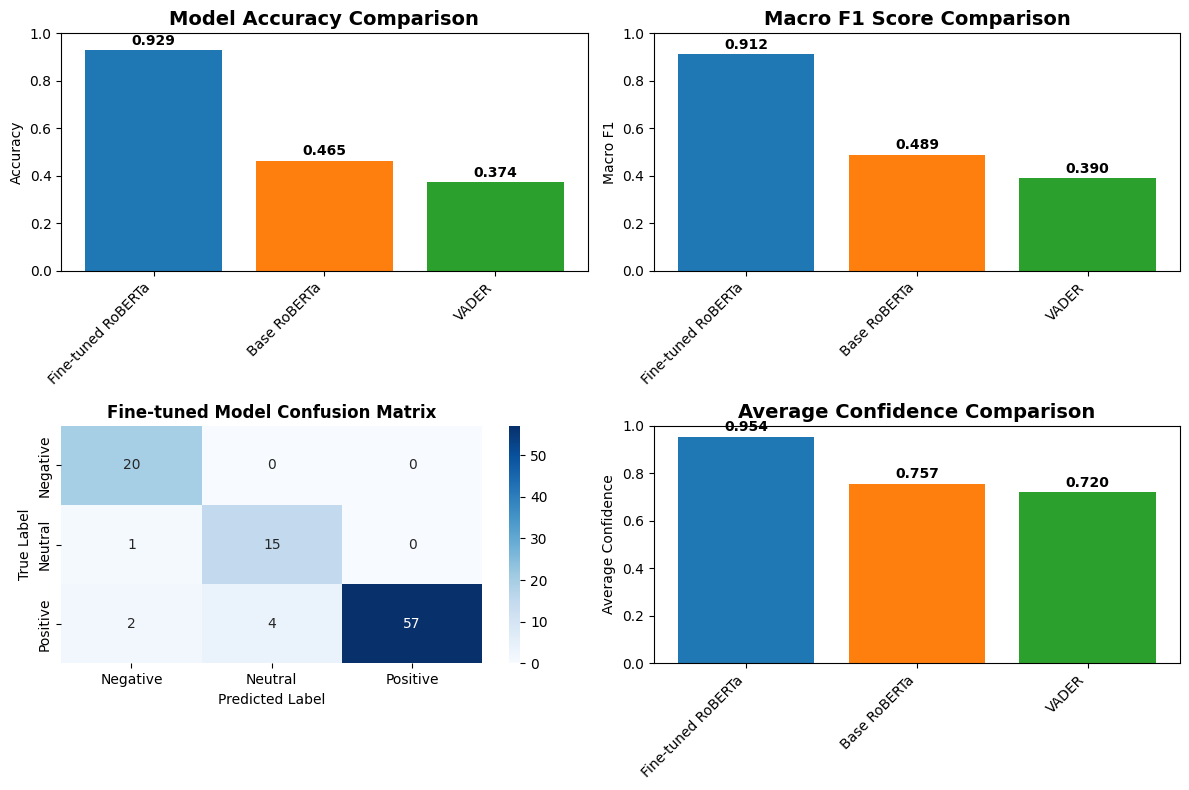


✅ Benchmark complete!


In [ ]:
#Model Benchmark against Vader and base model
!pip install -q transformers datasets scikit-learn vaderSentiment

import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import re
warnings.filterwarnings('ignore')

class ColabSentimentBenchmark:
    def __init__(self):
        """Initialize the benchmark for Google Colab environment"""
        self.test_data_path = "/content/headlines_labeled.csv"
        self.finetuned_model_path = "/content/sent_chk_v3"

        print("🚀 Starting Sentiment Analysis Benchmark")
        print("="*60)

        self._load_test_data()

        self.results = {}

    def _load_test_data(self):
        """Load and prepare test data"""
        print("📊 Loading test data...")

        df = pd.read_csv(self.test_data_path)

        for col in ["sentiment_label", "sentiment", "label"]:
            if col in df.columns:
                df = df.rename(columns={col: "sentiment_label"})
                break

        df["headline"] = df["headline"].apply(self._clean_text)
        df["sentiment_label"] = df["sentiment_label"].str.lower().str.strip()

        # Keep only valid labels and non-empty headlines
        valid_mask = (
            df["sentiment_label"].isin(["negative", "neutral", "positive"]) &
            (df["headline"] != "") &
            df["headline"].notna()
        )
        df = df[valid_mask].copy()

        # Use a held-out test set (20% of your data)
        from sklearn.model_selection import train_test_split

        # Split to get same test set that wasn't used in training
        _, self.df_test = train_test_split(
            df, test_size=0.2, random_state=42, stratify=df["sentiment_label"]
        )

        # Create label mappings
        self.label2id = {"negative": 0, "neutral": 1, "positive": 2}
        self.id2label = {v: k for k, v in self.label2id.items()}
        self.df_test["label"] = self.df_test["sentiment_label"].map(self.label2id)

        print(f"✅ Loaded {len(self.df_test)} test samples")
        print(f"📈 Class distribution: {self.df_test['sentiment_label'].value_counts().to_dict()}")

    def _clean_text(self, text):
        """Clean text same as training"""
        if pd.isna(text):
            return ""
        text = str(text).lower()
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'[^\w\s.,!?-]', '', text)
        text = re.sub(r'http\S+|www\S+', '', text)
        return text.strip()

    def test_finetuned_model(self):
        """Test your fine-tuned RoBERTa model"""
        print("\n🎯 TESTING FINE-TUNED MODEL")
        print("-" * 40)

        try:
            # Load your fine-tuned model
            tokenizer = AutoTokenizer.from_pretrained(self.finetuned_model_path)
            model = AutoModelForSequenceClassification.from_pretrained(self.finetuned_model_path)
            model.eval()

            predictions = []
            confidences = []

            print("Making predictions...")
            for headline in self.df_test["headline"]:
                # Tokenize
                inputs = tokenizer(
                    headline,
                    truncation=True,
                    padding="max_length",
                    max_length=128,
                    return_tensors="pt"
                )

                # Predict
                with torch.no_grad():
                    outputs = model(**inputs)
                    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
                    pred_class = probs.argmax().item()
                    confidence = probs.max().item()

                predictions.append(pred_class)
                confidences.append(confidence)

            # Calculate metrics
            accuracy = accuracy_score(self.df_test["label"], predictions)
            f1_macro = f1_score(self.df_test["label"], predictions, average="macro")
            f1_weighted = f1_score(self.df_test["label"], predictions, average="weighted")

            self.results["Fine-tuned RoBERTa"] = {
                "predictions": predictions,
                "accuracy": accuracy,
                "f1_macro": f1_macro,
                "f1_weighted": f1_weighted,
                "avg_confidence": np.mean(confidences)
            }

            print(f"✅ Accuracy: {accuracy:.4f}")
            print(f"✅ Macro F1: {f1_macro:.4f}")
            print(f"✅ Weighted F1: {f1_weighted:.4f}")
            print(f"✅ Avg Confidence: {np.mean(confidences):.4f}")

        except Exception as e:
            print(f"❌ Error testing fine-tuned model: {e}")

    def test_base_model(self):
        """Test base RoBERTa model (no fine-tuning)"""
        print("\n🤖 TESTING BASE ROBERTA MODEL")
        print("-" * 40)

        try:
            # Load base RoBERTa model
            model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
            tokenizer = AutoTokenizer.from_pretrained(model_name)
            model = AutoModelForSequenceClassification.from_pretrained(model_name)
            model.eval()

            predictions = []
            confidences = []

            print("Making predictions...")
            for headline in self.df_test["headline"]:
                # Tokenize
                inputs = tokenizer(
                    headline,
                    truncation=True,
                    padding="max_length",
                    max_length=128,
                    return_tensors="pt"
                )

                # Predict
                with torch.no_grad():
                    outputs = model(**inputs)
                    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

                    # Map base model predictions to our labels
                    # This model outputs: LABEL_0=negative, LABEL_1=neutral, LABEL_2=positive
                    pred_class = probs.argmax().item()
                    confidence = probs.max().item()

                predictions.append(pred_class)
                confidences.append(confidence)

            # Calculate metrics
            accuracy = accuracy_score(self.df_test["label"], predictions)
            f1_macro = f1_score(self.df_test["label"], predictions, average="macro")
            f1_weighted = f1_score(self.df_test["label"], predictions, average="weighted")

            self.results["Base RoBERTa"] = {
                "predictions": predictions,
                "accuracy": accuracy,
                "f1_macro": f1_macro,
                "f1_weighted": f1_weighted,
                "avg_confidence": np.mean(confidences)
            }

            print(f"✅ Accuracy: {accuracy:.4f}")
            print(f"✅ Macro F1: {f1_macro:.4f}")
            print(f"✅ Weighted F1: {f1_weighted:.4f}")
            print(f"✅ Avg Confidence: {np.mean(confidences):.4f}")

        except Exception as e:
            print(f"❌ Error testing base model: {e}")

    def test_vader(self):
        """Test VADER sentiment analyzer"""
        print("\n📚 TESTING VADER SENTIMENT")
        print("-" * 40)

        try:
            analyzer = SentimentIntensityAnalyzer()
            predictions = []
            confidences = []

            print("Making predictions...")
            for headline in self.df_test["headline"]:
                # Get VADER scores
                scores = analyzer.polarity_scores(headline)

                # Convert VADER compound score to our labels
                compound = scores['compound']

                if compound >= 0.05:
                    pred_class = 2  # positive
                    confidence = compound
                elif compound <= -0.05:
                    pred_class = 0  # negative
                    confidence = abs(compound)
                else:
                    pred_class = 1  # neutral
                    confidence = 1 - abs(compound)  # Higher confidence for neutral when compound near 0

                predictions.append(pred_class)
                confidences.append(confidence)

            # Calculate metrics
            accuracy = accuracy_score(self.df_test["label"], predictions)
            f1_macro = f1_score(self.df_test["label"], predictions, average="macro")
            f1_weighted = f1_score(self.df_test["label"], predictions, average="weighted")

            self.results["VADER"] = {
                "predictions": predictions,
                "accuracy": accuracy,
                "f1_macro": f1_macro,
                "f1_weighted": f1_weighted,
                "avg_confidence": np.mean(confidences)
            }

            print(f"✅ Accuracy: {accuracy:.4f}")
            print(f"✅ Macro F1: {f1_macro:.4f}")
            print(f"✅ Weighted F1: {f1_weighted:.4f}")
            print(f"✅ Avg Confidence: {np.mean(confidences):.4f}")

        except Exception as e:
            print(f"❌ Error testing VADER: {e}")

    def generate_report(self):
        """Generate comprehensive comparison report"""
        print("\n" + "="*60)
        print("🏆 FINAL BENCHMARK RESULTS")
        print("="*60)

        if not self.results:
            print("❌ No results to display!")
            return

        # Create results DataFrame
        results_data = []
        for model_name, metrics in self.results.items():
            results_data.append({
                "Model": model_name,
                "Accuracy": f"{metrics['accuracy']:.4f}",
                "Macro F1": f"{metrics['f1_macro']:.4f}",
                "Weighted F1": f"{metrics['f1_weighted']:.4f}",
                "Avg Confidence": f"{metrics['avg_confidence']:.4f}"
            })

        df_results = pd.DataFrame(results_data)

        # Sort by accuracy
        df_results["Accuracy_num"] = df_results["Accuracy"].astype(float)
        df_results = df_results.sort_values("Accuracy_num", ascending=False)
        df_results = df_results.drop("Accuracy_num", axis=1)

        print(df_results.to_string(index=False))

        # Declare winner
        print(f"\n🥇 WINNER: {df_results.iloc[0]['Model']}")
        print(f"   Best Accuracy: {df_results.iloc[0]['Accuracy']}")
        print(f"   Best Macro F1: {df_results.iloc[0]['Macro F1']}")

        # Performance improvements
        if len(df_results) > 1:
            best_acc = float(df_results.iloc[0]['Accuracy'])
            second_acc = float(df_results.iloc[1]['Accuracy'])
            improvement = ((best_acc - second_acc) / second_acc) * 100

            print(f"\n📈 Performance Improvement:")
            print(f"   {improvement:.2f}% better than {df_results.iloc[1]['Model']}")

        # Create visualization
        self._create_visualizations()

        return df_results

    def _create_visualizations(self):
        """Create comparison visualizations"""
        if len(self.results) < 2:
            return

        # Accuracy comparison bar chart
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 2, 1)
        models = list(self.results.keys())
        accuracies = [self.results[model]["accuracy"] for model in models]

        bars = plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(models)])
        plt.title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1)

        # Add value labels on bars
        for bar, acc in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

        plt.xticks(rotation=45, ha='right')

        # F1 Score comparison
        plt.subplot(2, 2, 2)
        f1_scores = [self.results[model]["f1_macro"] for model in models]

        bars = plt.bar(models, f1_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(models)])
        plt.title('Macro F1 Score Comparison', fontsize=14, fontweight='bold')
        plt.ylabel('Macro F1')
        plt.ylim(0, 1)

        for bar, f1 in zip(bars, f1_scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

        plt.xticks(rotation=45, ha='right')

        # Confusion matrix for best model (if fine-tuned model exists)
        if "Fine-tuned RoBERTa" in self.results:
            plt.subplot(2, 2, 3)
            cm = confusion_matrix(self.df_test["label"],
                                self.results["Fine-tuned RoBERTa"]["predictions"])

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['Negative', 'Neutral', 'Positive'],
                       yticklabels=['Negative', 'Neutral', 'Positive'])
            plt.title('Fine-tuned Model Confusion Matrix', fontsize=12, fontweight='bold')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')

        # Confidence comparison
        plt.subplot(2, 2, 4)
        confidences = [self.results[model]["avg_confidence"] for model in models]

        bars = plt.bar(models, confidences, color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(models)])
        plt.title('Average Confidence Comparison', fontsize=14, fontweight='bold')
        plt.ylabel('Average Confidence')
        plt.ylim(0, 1)

        for bar, conf in zip(bars, confidences):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{conf:.3f}', ha='center', va='bottom', fontweight='bold')

        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.show()

    def run_benchmark(self):
        """Run complete benchmark"""
        print("🚀 Starting complete benchmark...")

        # Test all models
        self.test_finetuned_model()
        self.test_base_model()
        self.test_vader()

        # Generate final report
        results_df = self.generate_report()

        print("\n✅ Benchmark complete!")
        return results_df

# Run the benchmark
benchmark = ColabSentimentBenchmark()
results = benchmark.run_benchmark()

In [ ]:
import shutil

# Create a zip file of your model
shutil.make_archive('/content/my_sentiment_model', 'zip', '/content/sent_chk_v3')

# Download the zip file
from google.colab import files
files.download('/content/my_sentiment_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>